In [1]:
import numpy as np
from skimage.filters import gaussian
import cv2 
import matplotlib.pyplot as plt
import pylab as pl

%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)
from tifffile import imread, imsave
import bobsegutils as bsu
from scipy.spatial.distance import euclidean
import csv
import math
from lm_tm import *
from MSER_kNN import mser_nearest

Populating the interactive namespace from numpy and matplotlib


In [2]:
def subVector(vec1, vec2):
    """Makes a vector given two points using B-A given the coordinates of two points A and B
       Parameters: Two lists of vectors
       Returns a list
    """
    return [(vec2[0] - vec1[0], vec2[1] - vec1[1]) for vec1, vec2 in zip(vec1, vec2)] 

In [3]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  
    """
    return vector / np.linalg.norm(vector)
def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

### Reads noisy image, denoised image and the corresponding csv file for tracklets to serve as GT

In [4]:
base_path = "/Users/prakash/Downloads/Junction_Coupling_Analysis/MAX_20180525_LP823_hmr-1_sax-7_RNAi_05-02_e2-crop//"
denoised_image_file_name = base_path+'MAX_20180525_LP823_hmr-1_sax-7_RNAi_05-02_Myo_denoised_e2-crop.tif'
csv_path = base_path+'MAX_20180525_LP823_hmr-1_sax-7_RNAi_05-02_e2-crop_tracklets.csv'
denoised_image = imread(denoised_image_file_name)
print('Shape of stack:', denoised_image.shape)
if((denoised_image.ndim) == 4):
    denoised_image = denoised_image[:,:,:,0]
    print(denoised_image.shape)

Shape of stack: (101, 652, 473)


### Extract flow vectors from tracklets in csv file

In [5]:
### Read the results csv file, delete all entries which are not coordinates and write it as a new csv file
puncta = []
edges = []
with open(csv_path,"r") as source:
    rdr= csv.reader( source )
    next(rdr)
    for line in source:
        if(line.startswith("edgep1,edgep2") ):
            break
        else:
            puncta.append(line[:-1])

edgeCount = False            
with open(csv_path,"r") as source:
    rdr= csv.reader( source )
    next(rdr)
    for line in source:
        if(line.startswith("edgep1,edgep2") ):
            edgeCount = True
        if(edgeCount):
            edges.append(line[:-1])
        

In [6]:
modified_edges = []
modified_puncta = []
for edge in range(1, len(edges)):
    modified_edges.append([float(edge) for edge in edges[edge].split(',')])
for punctum in range(len(puncta)):
    modified_puncta.append([float(punctum) for punctum in puncta[punctum].split(',')])

In [7]:
flow_vectors_gt = []
for edge in modified_edges:
    id1 = edge[0]
    id2 = edge[1]
    puncta1 = modified_puncta[int(id1)]
    puncta2 = modified_puncta[int(id2)]
    time_diff = np.abs(puncta1[-1] - puncta2[-1])
    if(puncta1[-1]<puncta2[-1] and time_diff ==1):
        time = int(puncta1[-1])
        x = puncta1[1]
        y = puncta1[2]
        u = puncta2[1] - puncta1[1]
        v = puncta2[2] - puncta1[2]
        
    elif(puncta2[-1]<puncta1[-1] and time_diff ==1):
        time = int(puncta2[-1])
        x = puncta2[1]
        y = puncta2[2]
        u = puncta1[1] - puncta2[1]
        v = puncta1[2] - puncta2[2]
    elif(puncta2[-1]==puncta1[-1]):
        continue
    flow_vectors_gt.append((x,y,u,v,time))

In [8]:
if len(set(flow_vectors_gt)) == len(flow_vectors_gt):
    print("no duplicates found!")

no duplicates found!


In [9]:
test_frac = int(len(flow_vectors_gt)*0.2)
random.shuffle(flow_vectors_gt)
test_set = flow_vectors_gt[0:test_frac]
train_set = flow_vectors_gt[test_frac:]

In [10]:
train_puncta = []
train_edges = []
iden = 0
for i in range(len(train_set)):
    x1 = train_set[i][0]
    y1 = train_set[i][1]
    time1 = int(train_set[i][4])
    x2 = x1+ train_set[i][2]
    y2 = y1+ train_set[i][3]
    time2 = time1+1
    computed_puncta1 = [iden, x1, y1, time1]
    computed_puncta1 = ','.join(map(str, computed_puncta1)) 
    computed_puncta2 = [iden+1, x2, y2, time2]
    computed_puncta2 = ','.join(map(str, computed_puncta2)) 
    train_puncta.append(computed_puncta1)
    train_puncta.append(computed_puncta2)
    iden+=2
train_puncta.insert(0, "id,x,y,t")

In [11]:
train_edges = []
for i in range(0, len(train_puncta)-1, 2):
    computed_edge = [i, i+1]
    computed_edge = ','.join(map(str, computed_edge)) 
    train_edges.append(computed_edge)
train_edges.insert(0, "edgep1,edgep2")
full = [train_puncta, train_edges]
a = []
for x in full:
    for y in x:
        a.append(y)

In [12]:
with open(base_path+ '/train_tracklets.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL,delimiter='\n')
    wr.writerow(a)

In [13]:
np.savez(base_path+"/test_set.npy", test_set)
# test_set = np.load(base_path+"/test_set.npy")

Now execute the GUI flow and save the flow image. Load it below.

In [14]:
flow = imread(base_path + "train_flow.tif")

# Comparison of automated GUI flow beofre denoising vs after denoising

### Load flow images obtained from GUI for both denoised and noisy images

#### Extract GT flow vectors and computed flow vectors

In [15]:
flow_vectors_computed = []
for vec in range(len(test_set)):
    int_x = round(test_set[vec][0])
    int_y = round(test_set[vec][1])
    time = test_set[vec][4]
    computed_u = flow[time][int_y][int_x]
    computed_v = flow[time+1][int_y][int_x]
    flow_vectors_computed.append((int_x, int_y, computed_u, computed_v, time))

In [16]:
final_coordinates_gt = []
final_coordinates_computed = []
initial_coordinates = []
for i in range(len(test_set)):
    
    final_coordinates_gt.append((test_set[i][0]+test_set[i][2], test_set[i][1]+test_set[i][3]))
    final_coordinates_computed.append((flow_vectors_computed[i][0]+flow_vectors_computed[i][2], flow_vectors_computed[i][1]+flow_vectors_computed[i][3]))
    initial_coordinates.append((test_set[i][0],test_set[i][1]))

In [17]:
lag_ = []
lag_rel_ = []
angle_ = []
for i in range(len(flow_vectors_computed)):
    u = flow_vectors_computed[i][2]
    v = flow_vectors_computed[i][3]
    u0 = train_set[i][2]
    v0 = train_set[i][3]
    len_vec=(u**2+v**2)**0.5
    len_vec0=(u0**2+v0**2)**0.5

    angle=angle_between((final_coordinates_computed[i]),( final_coordinates_gt[i]))*180/math.pi

    lag=len_vec-len_vec0
    
    lag_rel = (lag/len_vec0)*100
    lag_.append(lag)
    lag_rel_.append(lag_rel)
    
    angle_.append(angle)

In [18]:
print(np.median(lag_rel_), np.median(angle_))

-20.08475851126038 0.24551265270520953


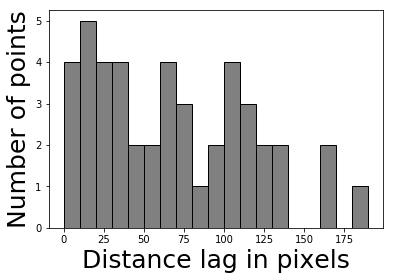

In [19]:
plt.hist(lag_rel_, bins=range(0,200,10), histtype='bar', color='gray', ec='black')
plt.xlabel('Distance lag in pixels',fontsize=25)
plt.ylabel('Number of points',fontsize=25)
plt.xticks(fontsize = 10) 
plt.yticks(fontsize = 10)
plt.show()

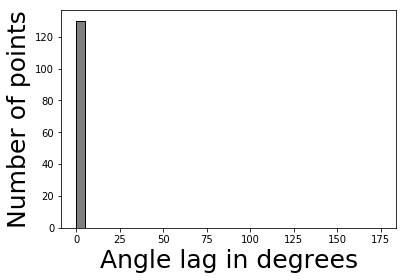

In [20]:
plt.hist(angle_, bins=range(0,180,5), histtype='bar', color='gray', ec='black')
plt.xlabel('Angle lag in degrees',fontsize=25)
plt.ylabel('Number of points',fontsize=25)
plt.xticks(fontsize = 10) 
plt.yticks(fontsize = 10)
plt.show()

In [21]:
flows = bsu.compute_flow( denoised_image )
flow_x, flow_y = bsu.split_flow_components( flows )
avg_flow_x = bsu.flow_average(flow_x, 1)
avg_flow_y = bsu.flow_average(flow_y, 1)
total_avg_flow_x = np.average(flow_x, axis=0)
total_avg_flow_y = np.average(flow_y, axis=0)

..................................................................................................... ...done!


In [22]:
# imsave(base_path + "OF_x.tif", avg_flow_x)
# imsave(base_path + "OF_y.tif", avg_flow_y)

In [23]:
flow_vectors_computed = []
for vec in range(len(test_set)):
    int_x = round(test_set[vec][0])
    int_y = round(test_set[vec][1])
    time = test_set[vec][4]
    computed_u = avg_flow_x[time][int_y][int_x]
    computed_v = avg_flow_y[time][int_y][int_x]
    flow_vectors_computed.append((int_x, int_y, computed_u, computed_v, time))

In [24]:
final_coordinates_gt = []
final_coordinates_computed = []
initial_coordinates = []
for i in range(len(test_set)):
    
    final_coordinates_gt.append((test_set[i][0]+test_set[i][2], test_set[i][1]+test_set[i][3]))
    final_coordinates_computed.append((flow_vectors_computed[i][0]+flow_vectors_computed[i][2], flow_vectors_computed[i][1]+flow_vectors_computed[i][3]))
    initial_coordinates.append((test_set[i][0],test_set[i][1]))

In [25]:
lag_ = []
lag_rel_ = []
angle_ = []
for i in range(len(flow_vectors_computed)):
    u = flow_vectors_computed[i][2]
    v = flow_vectors_computed[i][3]
    u0 = test_set[i][2]
    v0 = test_set[i][3]
    len_vec=(u**2+v**2)**0.5
    len_vec0=(u0**2+v0**2)**0.5

    angle=angle_between((final_coordinates_computed[i]),( final_coordinates_gt[i]))*180/math.pi
    
    lag=len_vec-len_vec0
    
    lag_rel = (lag/len_vec0)*100
    lag_.append(lag)
    lag_rel_.append(lag_rel)
    
    angle_.append(angle)

In [26]:
print(np.median(lag_rel_), np.median(angle_))

-31.841117198564493 0.1198538462540307


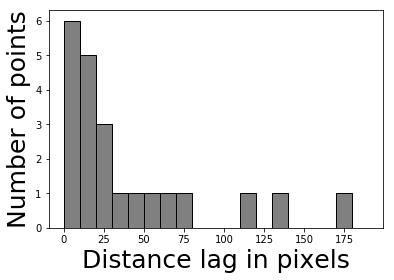

In [27]:
plt.hist(lag_rel_, bins=range(0,200,10), histtype='bar', color='gray', ec='black')
plt.xlabel('Distance lag in pixels',fontsize=25)
plt.ylabel('Number of points',fontsize=25)
plt.xticks(fontsize = 10) 
plt.yticks(fontsize = 10)
plt.show()

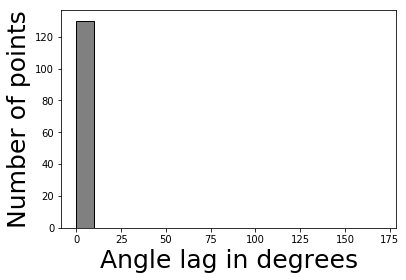

In [28]:
plt.hist(angle_, bins=range(0,180,10), histtype='bar', color='gray', ec='black')
plt.xlabel('Angle lag in degrees',fontsize=25)
plt.ylabel('Number of points',fontsize=25)
plt.xticks(fontsize = 10) 
plt.yticks(fontsize = 10)
plt.show()

### Export computed tracklets for visulaization in GUI

In [29]:
iden = 0
visulaizatiuon_puncta = []
for i in range(len(flow_vectors_gt)):
    
    x1 = flow_vectors_gt[i][0]
    y1 = flow_vectors_gt[i][1]
    time1 = int(flow_vectors_gt[i][4])
    x2 = final_coordinates_computed[i][0]
    y2 = final_coordinates_computed[i][1]
    time2 = time1+1
    computed_puncta1 = [iden, x1, y1, time1]
    computed_puncta1 = ','.join(map(str, computed_puncta1)) 
    computed_puncta2 = [iden+1, x2, y2, time2]
    computed_puncta2 = ','.join(map(str, computed_puncta2)) 
    visulaizatiuon_puncta.append(computed_puncta1)
    visulaizatiuon_puncta.append(computed_puncta2)
    iden+=2
visulaizatiuon_puncta.insert(0, "id,x,y,t")

In [30]:
visualization_edges = []
for i in range(0, len(visulaizatiuon_puncta), 2):
    computed_edge = [i, i+1]
    computed_edge = ','.join(map(str, computed_edge)) 
    visualization_edges.append(computed_edge)
visualization_edges.insert(0, "edgep1,edgep2")
full = [visulaizatiuon_puncta, visualization_edges]
a = []
for x in full:
    for y in x:
        a.append(y)

In [31]:
with open(base_path+ '/OF_visualization_tracklets.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL,delimiter='\n')
    wr.writerow(a)